In [102]:
%pip -q install xgboost
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    average_precision_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [104]:
preprocessor = joblib.load("../artifacts/preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("../artifacts/splits.joblib")

In [105]:

from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results = cross_validate(
    log_reg,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1", "roc_auc"],
    return_train_score=True
)
print("CV F1 (train):", np.mean(cv_results["train_f1"]))
print("CV F1 (val):", np.mean(cv_results["test_f1"]))

print("CV ROC-AUC (train):", np.mean(cv_results["train_roc_auc"]))
print("CV ROC-AUC (val):", np.mean(cv_results["test_roc_auc"]))

log_reg.fit(X_train, y_train)



CV F1 (train): 0.9930068907700488
CV F1 (val): 0.985831608005521
CV ROC-AUC (train): 0.994706410528089
CV ROC-AUC (val): 0.9909109477124183


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [106]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("FINAL TEST RESULTS")
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
joblib.dump(log_reg, "../artifacts/log_reg_model.joblib")


FINAL TEST RESULTS
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



['../artifacts/log_reg_model.joblib']

In [107]:
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results_rf = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1", "roc_auc"],
    return_train_score=True
)

print("RF CV F1 (train):", np.mean(cv_results_rf["train_f1"]))
print("RF CV F1 (val):", np.mean(cv_results_rf["test_f1"]))

print("RF CV ROC-AUC (train):", np.mean(cv_results_rf["train_roc_auc"]))
print("RF CV ROC-AUC (val):", np.mean(cv_results_rf["test_roc_auc"]))

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))
joblib.dump(rf, "../artifacts/rf.joblib")

RF CV F1 (train): 1.0
RF CV F1 (val): 0.994443372564152
RF CV ROC-AUC (train): 1.0
RF CV ROC-AUC (val): 0.9996732026143791
Random Forest
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



['../artifacts/rf.joblib']

In [108]:

from sklearn.model_selection import permutation_test_score

score, perm_scores, pvalue = permutation_test_score(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring="f1",
    n_permutations=100,
    random_state=42
)

print("Permutation F1:", score)
print("p-value:", pvalue)


Permutation F1: 0.994443372564152
p-value: 0.009900990099009901


In [109]:
mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=42
        ))
    ]
)


cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results_mlp = cross_validate(
    mlp,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1", "roc_auc"],
    return_train_score=True
)

print("MLP CV F1 (train):", np.mean(cv_results_mlp["train_f1"]))
print("MLP CV F1 (val):", np.mean(cv_results_mlp["test_f1"]))

print("MLP CV ROC-AUC (train):", np.mean(cv_results_mlp["train_roc_auc"]))
print("MLP CV ROC-AUC (val):", np.mean(cv_results_mlp["test_roc_auc"]))


mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

print("MLP Classifier")
print("F1:", f1_score(y_test, y_pred_mlp))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_mlp))
print(classification_report(y_test, y_pred_mlp))
joblib.dump(mlp, "../artifacts/mlp.joblib")

MLP CV F1 (train): 0.9993079584775086
MLP CV F1 (val): 0.994443372564152
MLP CV ROC-AUC (train): 1.0
MLP CV ROC-AUC (val): 0.9993259803921568
MLP Classifier
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



['../artifacts/mlp.joblib']

In [110]:

xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        ))
    ]
)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_results_xgb = cross_validate(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring=["f1", "roc_auc"],
    return_train_score=True
)

print("XGB CV F1 (train):", np.mean(cv_results_xgb["train_f1"]))
print("XGB CV F1 (val):", np.mean(cv_results_xgb["test_f1"]))

print("XGB CV ROC-AUC (train):", np.mean(cv_results_xgb["train_roc_auc"]))
print("XGB CV ROC-AUC (val):", np.mean(cv_results_xgb["test_roc_auc"]))
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost")
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))
joblib.dump(xgb, "../artifacts/xgb.joblib")

XGB CV F1 (train): 0.999298245614035
XGB CV F1 (val): 0.9915459882583171
XGB CV ROC-AUC (train): 1.0
XGB CV ROC-AUC (val): 0.9993259803921568
XGBoost
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



['../artifacts/xgb.joblib']

In [111]:

def full_metrics(y_true, y_pred, y_score):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "PR_AUC": average_precision_score(y_true, y_score),
    }


In [112]:
results = []

results.append({"Model": "LogReg", **full_metrics(y_test, y_pred, y_proba)})
results.append({"Model": "RandomForest", **full_metrics(y_test, y_pred_rf, y_proba_rf)})
results.append({"Model": "MLP", **full_metrics(y_test, y_pred_mlp, y_proba_mlp)})
results.append({"Model": "XGBoost", **full_metrics(y_test, y_pred_xgb, y_proba_xgb)})

df_results = (
    pd.DataFrame(results)
    .set_index("Model")
    .sort_values("PR_AUC", ascending=False)
)
print(df_results)

              Accuracy  Precision  Recall   F1  ROC_AUC  PR_AUC
Model                                                          
LogReg             1.0        1.0     1.0  1.0      1.0     1.0
RandomForest       1.0        1.0     1.0  1.0      1.0     1.0
XGBoost            1.0        1.0     1.0  1.0      1.0     1.0
MLP                1.0        1.0     1.0  1.0      1.0     1.0


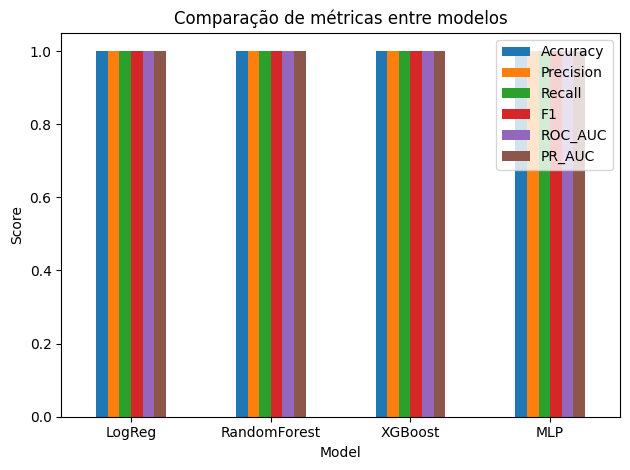

In [113]:
ax = df_results[
    ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "PR_AUC"]
].plot(kind="bar", rot=0)

ax.set_title("Comparação de métricas entre modelos")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

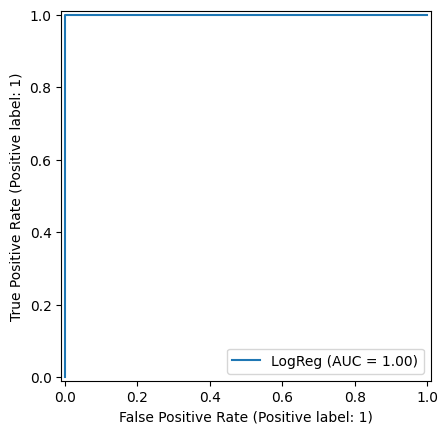

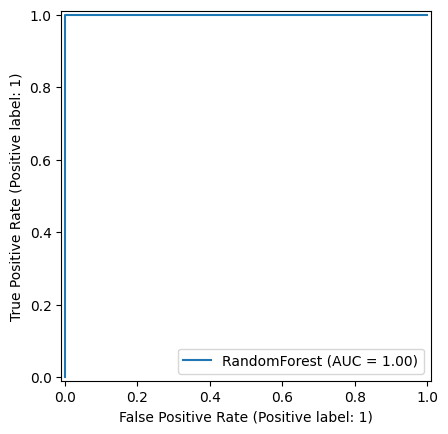

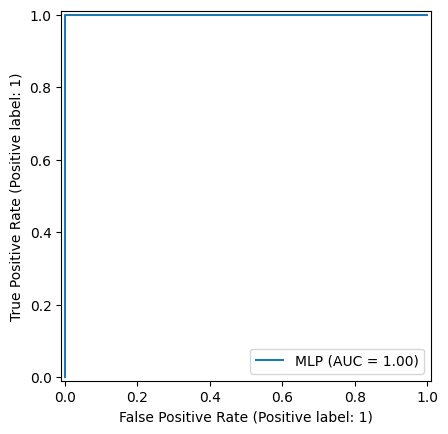

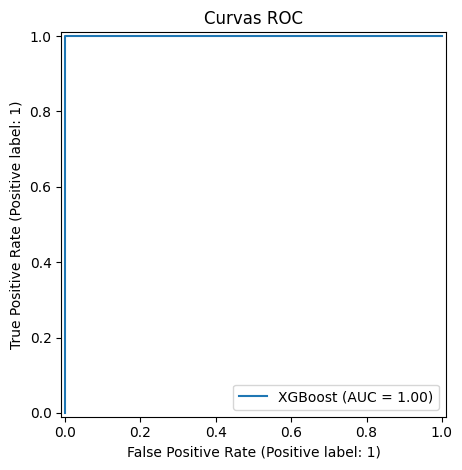

In [114]:

plt.figure()
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name="LogReg")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="RandomForest")
RocCurveDisplay.from_estimator(mlp, X_test, y_test, name="MLP")
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost")
plt.title("Curvas ROC")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

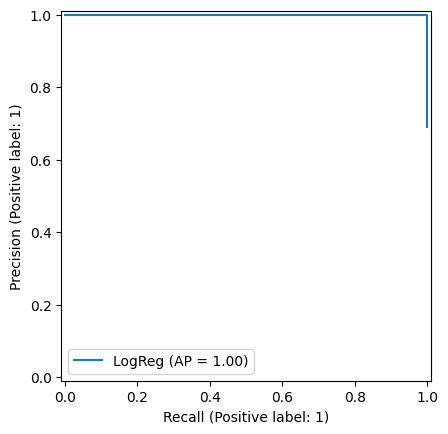

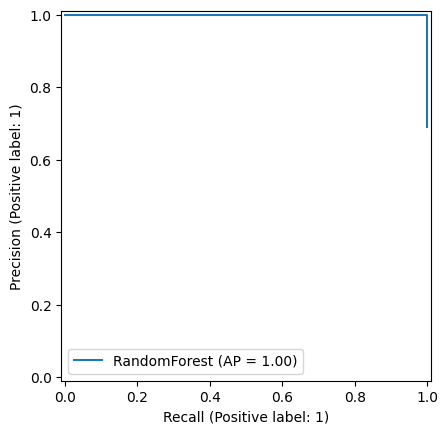

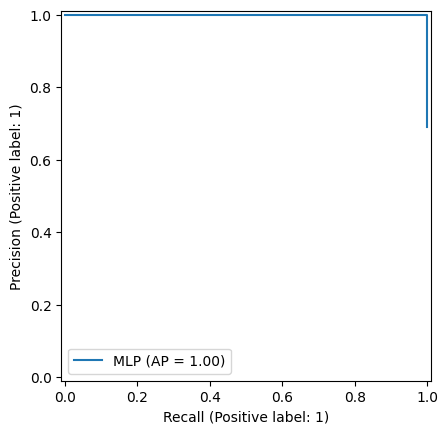

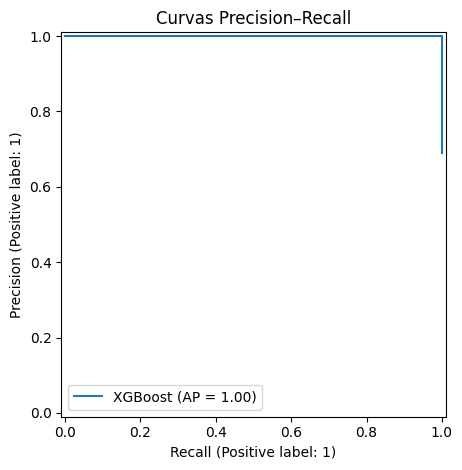

In [115]:
plt.figure()
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test, name="LogReg")
PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, name="RandomForest")
PrecisionRecallDisplay.from_estimator(mlp, X_test, y_test, name="MLP")
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost")
plt.title("Curvas Precision–Recall")
plt.tight_layout()
plt.show()

Melhor modelo (PR_AUC): LogReg


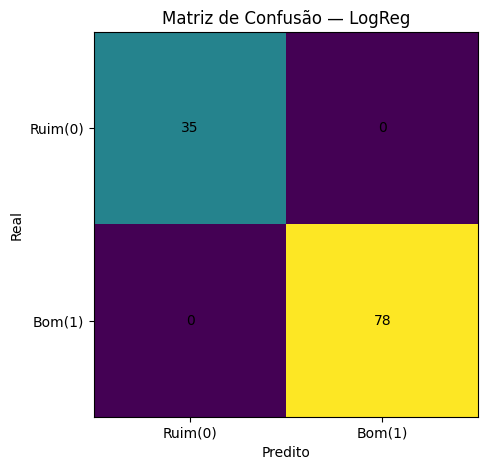

In [116]:
best_model_name = df_results["PR_AUC"].idxmax()
print("Melhor modelo (PR_AUC):", best_model_name)

model_map = {
    "LogReg": log_reg,
    "RandomForest": rf,
    "MLP": mlp,
    "XGBoost": xgb
}

best_model = model_map[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure()
plt.imshow(cm)
plt.title(f"Matriz de Confusão — {best_model_name}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.xticks([0,1], ["Ruim(0)", "Bom(1)"])
plt.yticks([0,1], ["Ruim(0)", "Bom(1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [117]:

df_results.to_csv("../artifacts/benchmark_metrics.csv")
print("Benchmark salvo em artifacts/")

Benchmark salvo em artifacts/
